$$\textbf{\Huge{Eigenworm Final}}$$
$$\textit{{Ben and Neta}}$$

# Q1   
### Find an embedding for the data that will separate the swimming and crawling worms.

In [31]:
import pandas as pd
import numpy as np
from preProcess_fun import preProcess 
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
path=r"C:\Users\benia\VScodeprojects\Physical_Models\doi_10_5061_dryad_stqjq2c8p__v20240130\dryad"
data=preProcess(path,2,All=False)
movements = data['movement'].unique()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The first method try is PCA, it finds the eigenvectors of the covariance matrix of the data (Σ) and sorts them by their corresponding eigenvalues (𝜆). These eigenvectors represent the directions of maximum variance. The goal is to minimize the reconstruction error ($∥𝑋−𝑋_{\text{reconstructed}}∥^2$), where 𝑋 is the original data and $𝑋_{\text{reconstructed}}$ is the data represented in reduced dimensions using the selected eigenvectors. This minimization preserves the most important information in the data by maximizing the variance explained in each successive eigenvector.


In [32]:
# Drop non-numerical columns
df_numeric = data.select_dtypes(include=[np.number])

# Convert DataFrame to numpy array
M = df_numeric.values
# Subtract the mean
M = M - np.mean(M, axis=0)
# Compute the covariance matrix
cov_matrix = np.cov(M, rowvar=False)

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Compute the eigenvalues and eigenvectors of the covariance matrix
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

# Get the first two eigenvectors
pca_1 = eigenvectors[:, 0]
pca_2 = eigenvectors[:, 1]
pca_3 = eigenvectors[:, 2]

# Project the data onto the first two eigenvectors
projected_data = df_numeric.dot(np.array([pca_1, pca_2,pca_3]).T)


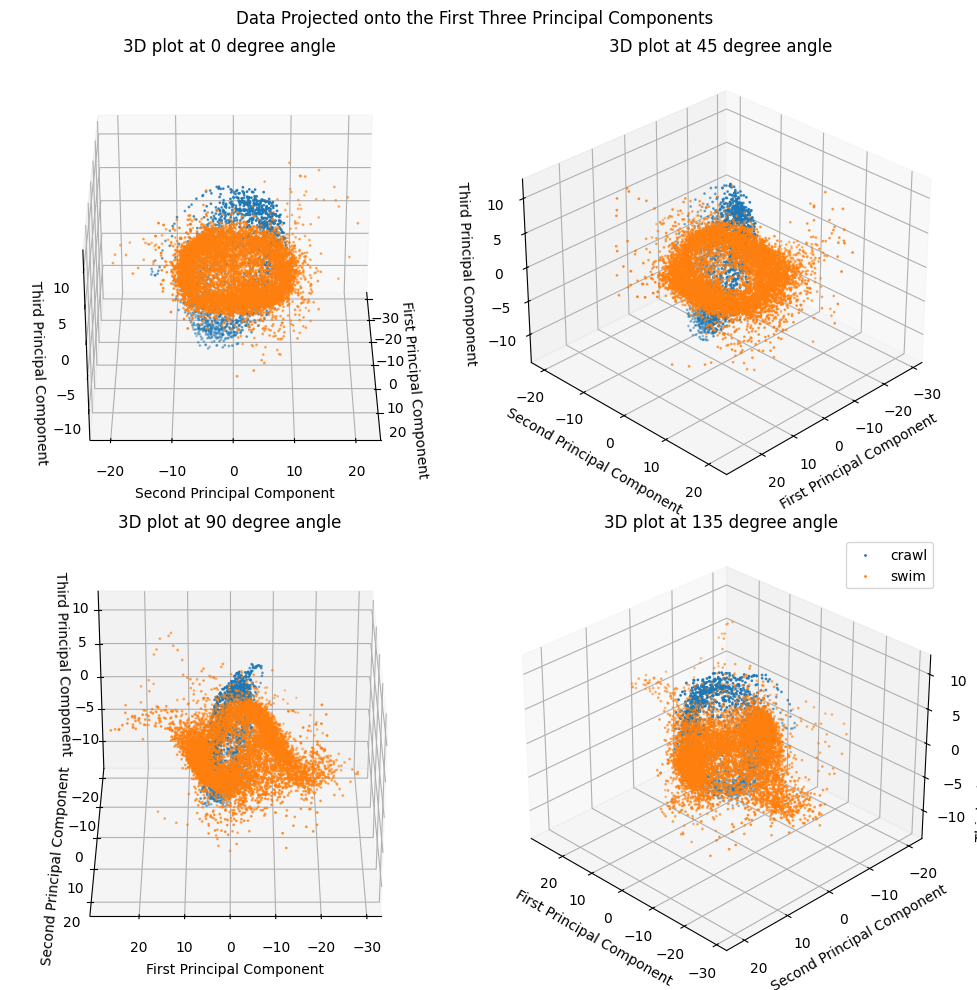

In [34]:
fig = plt.figure(figsize=(10, 10))

angles = [0, 45, 90, 135]

for i, angle in enumerate(angles, start=1):
    ax = fig.add_subplot(2, 2, i, projection='3d')
    for movement in movements:
        mask = data['movement'] == movement
        ax.scatter(projected_data[0][mask], projected_data[1][mask], projected_data[2][mask], label=movement, s=1)
    ax.set_xlabel('First Principal Component')
    ax.set_ylabel('Second Principal Component')
    ax.set_zlabel('Third Principal Component')
    ax.view_init(30, angle)
    ax.set_title(f'3D plot at {angle} degree angle')

plt.suptitle('Data Projected onto the First Three Principal Components')
plt.legend()
plt.tight_layout()
plt.show()

The next method try is ICA. Independent Component Analysis (ICA) a method for separating mixed signals into independent components. It aims to find a linear transformation such that resulting components are statistically independent. This reduces data dimensionality by extracting unique sources of variation. ICA maximizes independence between components, often using measures related to mutual information like negentropy or kurtosis. This is useful when traditional methods like PCA fail to capture underlying structure due to their assumption of orthogonality rather than independence.

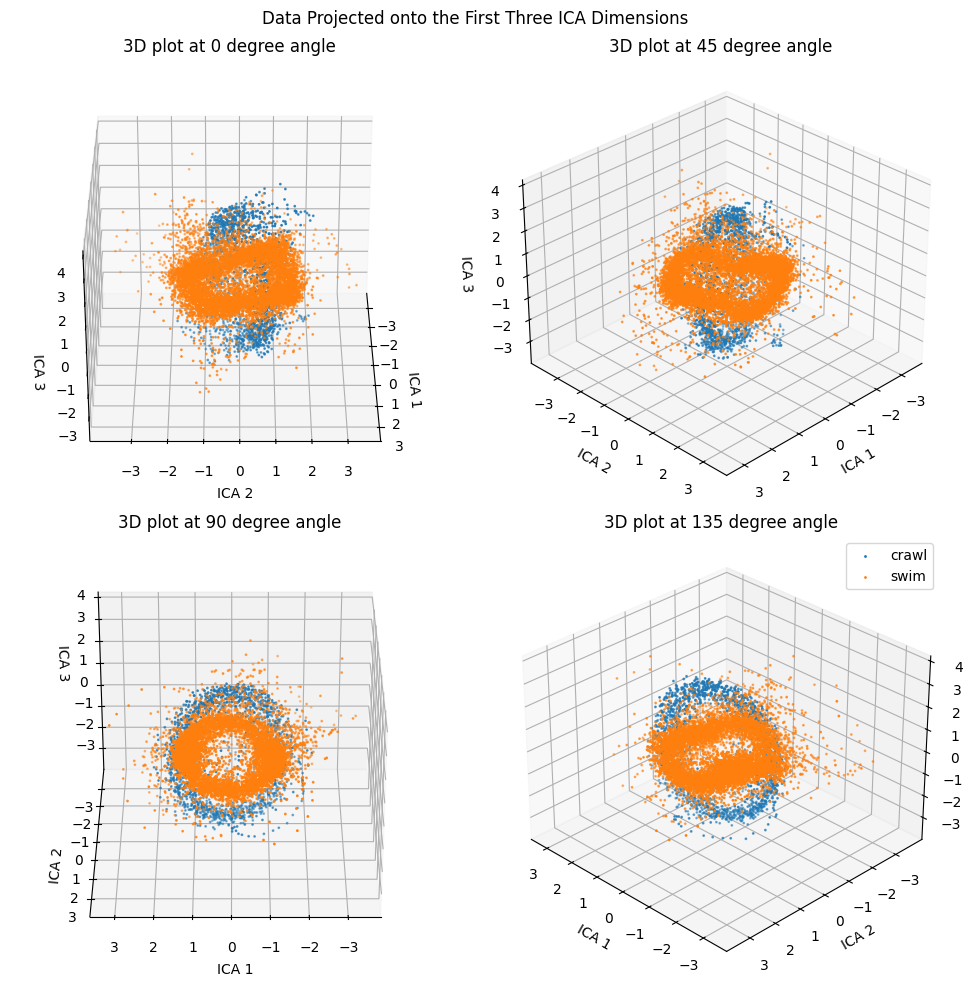

In [35]:
from sklearn.decomposition import FastICA

# Perform ICA dimensionality reduction
ica = FastICA(n_components=4, random_state=0)
ica_data = ica.fit_transform(df_numeric)

fig = plt.figure(figsize=(10, 10))

angles = [0, 45, 90, 135]

for i, angle in enumerate(angles, start=1):
    ax = fig.add_subplot(2, 2, i, projection='3d')
    for movement in movements:
        mask = data['movement'] == movement
        ax.scatter(ica_data[mask,0], ica_data[mask,1], ica_data[mask,2], label=movement, s=1)
    ax.set_xlabel('ICA 1')
    ax.set_ylabel('ICA 2')
    ax.set_zlabel('ICA 3')
    ax.view_init(30, angle)
    ax.set_title(f'3D plot at {angle} degree angle')

plt.suptitle('Data Projected onto the First Three ICA Dimensions')
plt.legend()
plt.tight_layout()
plt.show()



The next method we utilized is t-SNE, a non-linear dimensionality reduction technique that effectively embeds high-dimensional data into a lower-dimensional space by focusing on local data structures. It starts by converting Euclidean distances between data points into conditional probabilities that express pairwise similarities. t-SNE then optimizes the low-dimensional embedding to minimize the Kullback-Leibler divergence between the joint probability distributions 
$P$ in the high-dimensional space and 
$Q$ in the low-dimensional space, ensuring that similar data points remain close in the reduced space. Thus the obejctive function is:
$$\text{argmin}_{Y} \left( KL(P \parallel Q) = \sum_{i, j} p_{ij} \log \frac{p_{ij}}{q_{ij}} \right)$$

where $Y$ corresponds to the coordinates of a data point in this reduced space


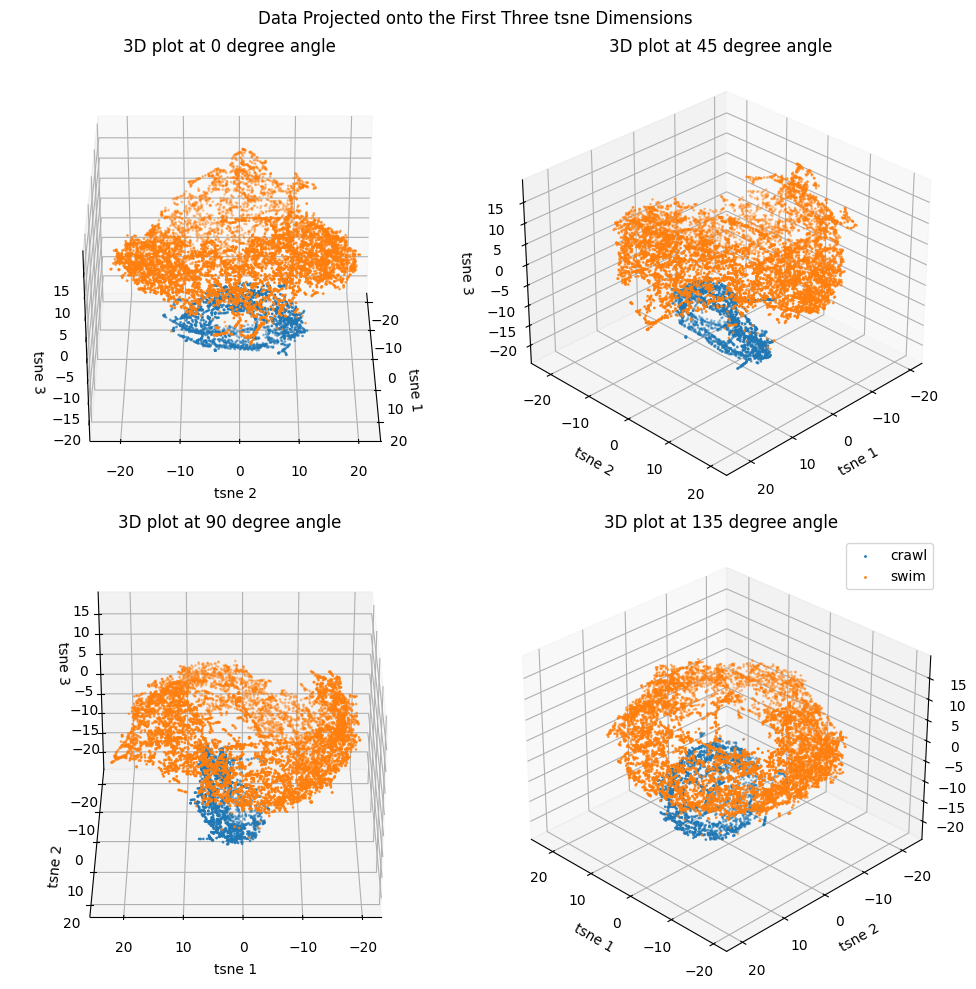

In [36]:
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=3)
tsne_embedding = tsne.fit_transform(df_numeric)
fig = plt.figure(figsize=(10, 10))

angles = [0, 45, 90, 135]

for i, angle in enumerate(angles, start=1):
    ax = fig.add_subplot(2, 2, i, projection='3d')
    for movement in movements:
        mask = data['movement'] == movement
        ax.scatter(tsne_embedding[mask,0], tsne_embedding[mask,1], tsne_embedding[mask,2], label=movement, s=1)
    ax.set_xlabel('tsne 1')
    ax.set_ylabel('tsne 2')
    ax.set_zlabel('tsne 3')
    ax.view_init(30, angle)
    ax.set_title(f'3D plot at {angle} degree angle')

plt.suptitle('Data Projected onto the First Three tsne Dimensions')
plt.legend()
plt.tight_layout()
plt.show()

The next method we utilized is Laplacian eigenmaps, that approximates a manifold upon which the data lies. It constructs a graph where each data point is a node and the edges represent the similarity between the data points. The Laplacian matrix is then constructed from this graph, and the eigenvectors of this matrix represent the embedding of the data points in a lower-dimensional space. The goal is to minimize the Laplacian operator of the data points in the reduced space,  the objective function is:

$$\text{argmin}_{Y} \left(\frac{1}{2}\sum_{ij}||y_i-y_j||W_{ij}\right)=\text{argmin}_{Y}\left( \text{Tr}(Y^TLY) \right)$$

where $Y$ corresponds to the coordinates of a data point in this reduced space. $L$ is the Laplacian matrix and $W$ is the weight matrix that represents the similarity between data points. If data points are not connected on the graph it means $W_{ij}=0$ hence when those points are distant in the embedding space theres no additional value to the sum, thus Laplacian eigenmaps only preseves the local structure of the data.  

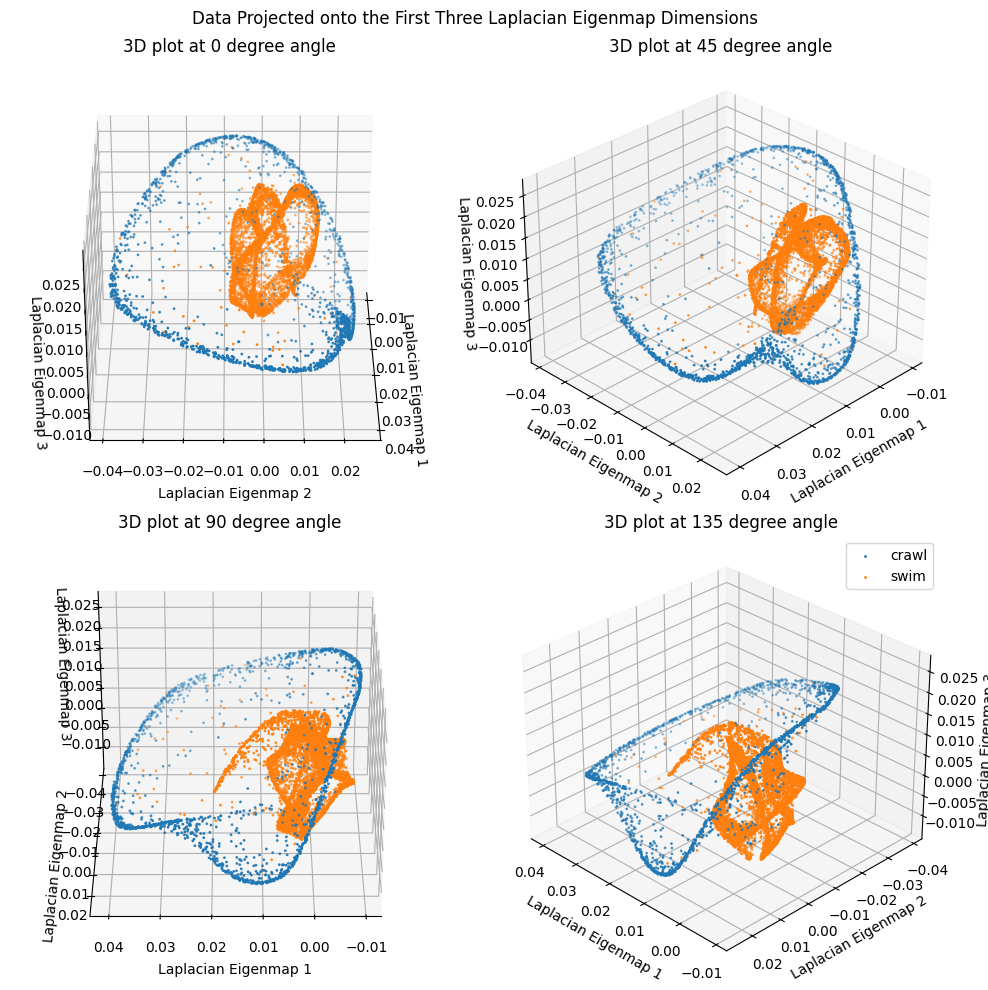

In [37]:
import numpy as np
from sklearn.neighbors import kneighbors_graph
from scipy.sparse import diags
from scipy.sparse.linalg import eigsh
from mpl_toolkits.mplot3d import Axes3D

# Create a graph of nearest neighbors
n_neighbors = 100  # You can adjust this parameter
A = kneighbors_graph(df_numeric, n_neighbors, include_self=False)
A.data = np.exp(-A.data**2)
# Compute the degree matrix
D = diags(A.sum(axis=1).A1)

# Compute the Laplacian matrix
L = D - A

# Compute the eigenvalues and eigenvectors of the Laplacian matrix
Leigvals, Leigvecs = eigsh(L, k=6, which='SM')

L_embedding = Leigvecs[:, 0:4]

import numpy as np
from sklearn.neighbors import kneighbors_graph
from scipy.sparse import diags
from scipy.sparse.linalg import eigsh
from mpl_toolkits.mplot3d import Axes3D

# Create a graph of nearest neighbors
n_neighbors = 100  # You can adjust this parameter
A = kneighbors_graph(df_numeric, n_neighbors, include_self=False)
A.data = np.exp(-A.data**2)
# Compute the degree matrix
D = diags(A.sum(axis=1).A1)

# Compute the Laplacian matrix
L = D - A

# Compute the eigenvalues and eigenvectors of the Laplacian matrix
Leigvals, Leigvecs = eigsh(L, k=6, which='SM')

L_embedding = Leigvecs[:, 0:4]

fig = plt.figure(figsize=(10, 10))

angles = [0, 45, 90, 135]

for i, angle in enumerate(angles, start=1):
    ax = fig.add_subplot(2, 2, i, projection='3d')
    for movement in movements:
        mask = data['movement'] == movement
        ax.scatter(L_embedding[mask,1], L_embedding[mask,2], L_embedding[mask,3], label=movement, s=1)
    ax.set_xlabel('Laplacian Eigenmap 1')
    ax.set_ylabel('Laplacian Eigenmap 2')
    ax.set_zlabel('Laplacian Eigenmap 3')
    ax.view_init(30, angle)
    ax.set_title(f'3D plot at {angle} degree angle')

plt.suptitle('Data Projected onto the First Three Laplacian Eigenmap Dimensions')
plt.legend()
plt.tight_layout()
plt.show()


The last method we use is diffusion maps. It constructs a Markov matrix from the data points, where each row represents the probability distribution of transitioning from one data point to another. Since we take the power of the Markov matrix, it represents the probability distribution of transitioning from one data point to another after a certain number of steps, hence the globally important data points (or the central nodes) are emphasized in the embedding space. 

In [38]:

from scipy.spatial.distance import pdist, squareform
from scipy.sparse import csr_matrix, diags

# Step 1: Compute the pairwise distance matrix
dist_matrix = csr_matrix(squareform(pdist(df_numeric)))

# Step 2: Compute the kernel matrix
sigma = np.median(dist_matrix.data)  # This is a common choice for the kernel bandwidth
dist_matrix.data = np.exp(-dist_matrix.data ** 2 / (2 * sigma ** 2))

# Step 3: Normalize the kernel matrix to get the transition matrix
row_sums = np.array(dist_matrix.sum(axis=1)).ravel()
transition_matrix = diags(1 / row_sums).dot(dist_matrix)

# Step 4: Compute the eigenvalues and eigenvectors of the transition matrix
Aeigvals, Aeigvecs = eigsh(transition_matrix**2, k=6, which='LM')

# Step 5: The diffusion map is given by the eigenvectors scaled by the corresponding eigenvalues
diffusion_map = Aeigvecs * Aeigvals


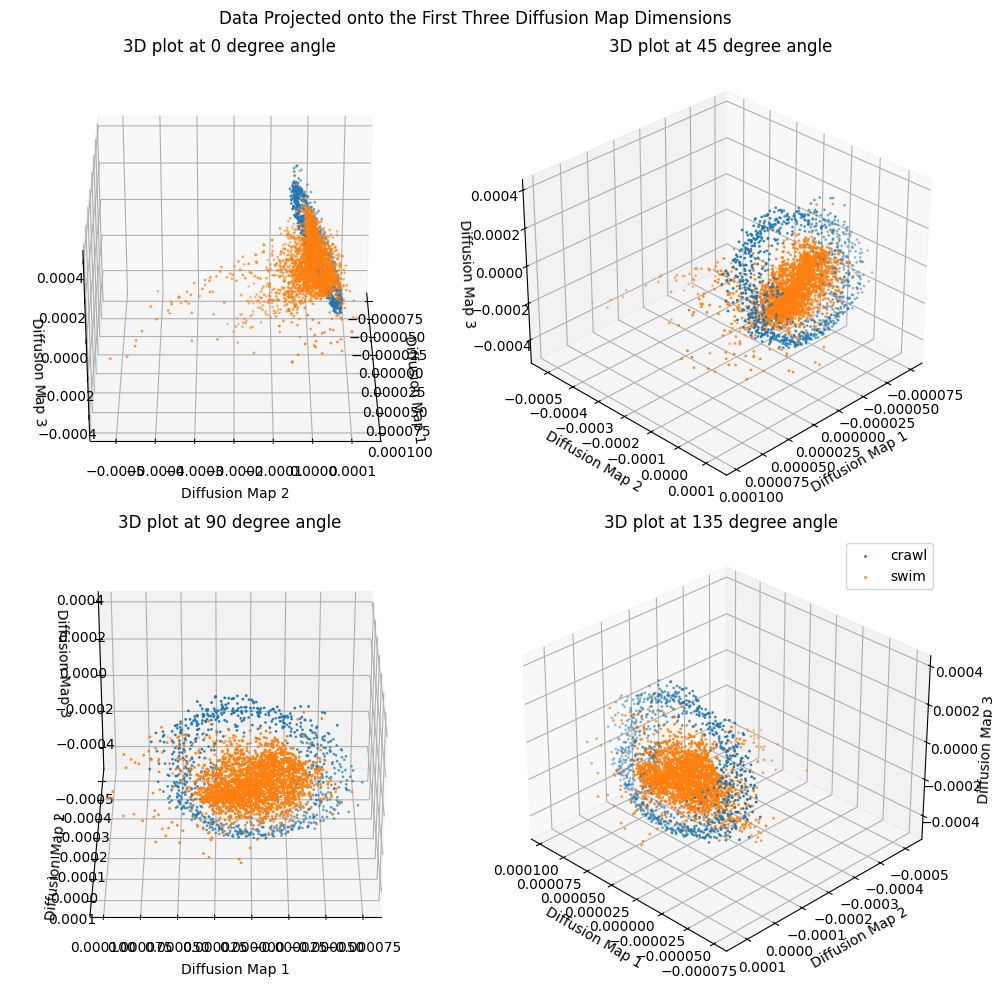

In [ ]:
fig = plt.figure(figsize=(10, 10))

angles = [0, 45, 90, 135]

for i, angle in enumerate(angles, start=1):
    ax = fig.add_subplot(2, 2, i, projection='3d')
    for movement in movements:
        mask = data['movement'] == movement
        ax.scatter(diffusion_map[mask,0], diffusion_map[mask,1], diffusion_map[mask,2], label=movement, s=1)
    ax.set_xlabel('Diffusion Map 1')
    ax.set_ylabel('Diffusion Map 2')
    ax.set_zlabel('Diffusion Map 3')
    ax.view_init(30, angle)
    ax.set_title(f'3D plot at {angle} degree angle')

plt.suptitle('Data Projected onto the First Three Diffusion Map Dimensions')
plt.legend()
plt.tight_layout()
plt.show()

# Q2  a) 

### Quantify how the embeddings from the different methods compare ?

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
# Assuming 'data' is your DataFrame containing the 'movement' column with categorical labels
true_labels = data['movement'].values

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit LabelEncoder and transform labels
true_labels_numeric = label_encoder.fit_transform(true_labels)
methods = ["PCA", "ICA", "t-SNE", "Laplacian Eigenmaps", "Diffusion Maps"]
# Check the mapping of original labels to numeric labels
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

def calculate_mismatch(labels1, labels2):

    # Convert lists to numpy arrays
    labels1 = np.array(labels1)
    labels2 = np.array(labels2)
    
    # Calculate mismatch for the original labels
    mismatch_original = (labels1 != labels2).mean() * 100
    
    # Flip labels1 (e.g., changing 0 to 1 and 1 to 0)
    labels1_flipped = 1 - labels1
    
    # Calculate mismatch for the flipped labels
    mismatch_flipped = (labels1_flipped != labels2).mean() * 100
    
    # Return the minimum mismatch percentage
    return min(mismatch_original, mismatch_flipped)


n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
clusters1_pca = kmeans.fit_predict(projected_data)
clusters1_ica = kmeans.fit_predict(ica_data[:,0:3])
clusters1_tsne = kmeans.fit_predict(tsne_embedding[:,0:3])
clusters1_laplacian = kmeans.fit_predict(L_embedding[:,0:3])
clusters1_diffusion = kmeans.fit_predict(diffusion_map[:,0:3])
gmm=GaussianMixture(n_components=n_clusters, random_state=0)
clusters_pca = gmm.fit_predict(projected_data)
clusters_ica = gmm.fit_predict(ica_data[:,0:3])
clusters_tsne = gmm.fit_predict(tsne_embedding[:,0:3])
clusters_laplacian = gmm.fit_predict(L_embedding[:,0:3])
clusters_diffusion = gmm.fit_predict(diffusion_map[:,0:3])

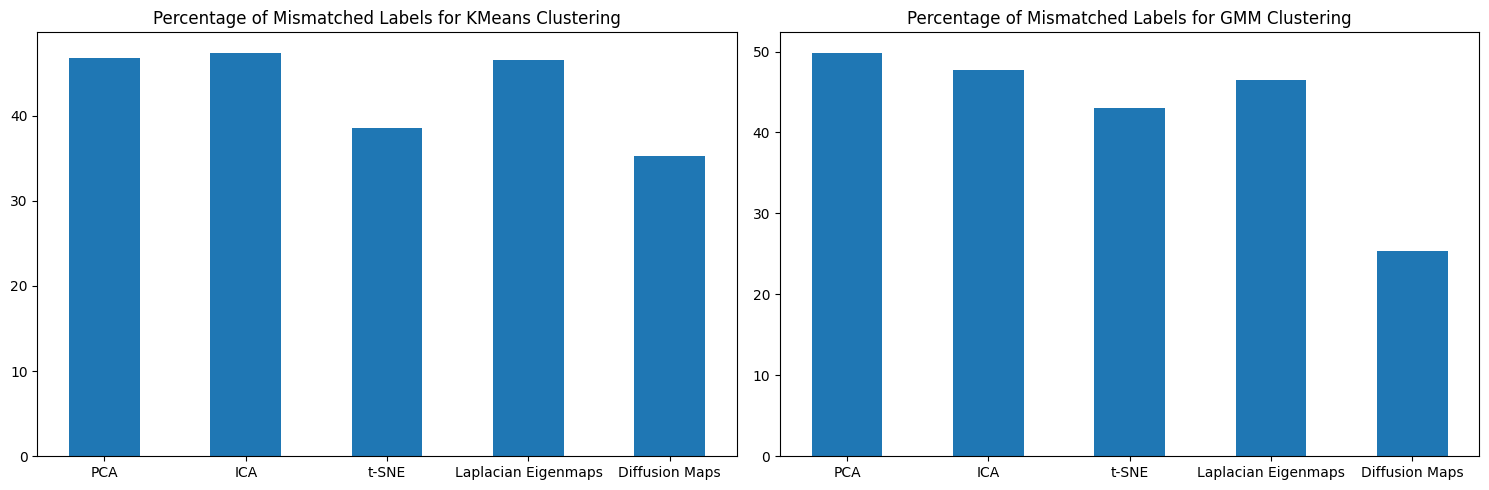

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

percents=[]
for clusters, method in zip([clusters1_pca, clusters1_ica, clusters1_tsne, clusters1_laplacian, clusters1_diffusion], methods):
    # Calculate the percentage of mismatched labels
    percents.append(calculate_mismatch(clusters, true_labels_numeric))

axs[0].bar(methods, percents, width=0.5)  # Set width to 0.3
axs[0].set_title('Percentage of Mismatched Labels for KMeans Clustering')

percents=[]
for clusters, method in zip([clusters_pca, clusters_ica, clusters_tsne, clusters_laplacian, clusters_diffusion], methods):
    # Calculate the percentage of mismatched labels
    percents.append(calculate_mismatch(clusters, true_labels_numeric))

axs[1].bar(methods, percents, width=0.5)  # Set width to 0.3
axs[1].set_title('Percentage of Mismatched Labels for GMM Clustering')

plt.tight_layout()
plt.show()


Here we used two methods as a method to cluster the data, K-means and Gaussian Mixture Model (which we learned in the course).

# Q2  b)
### What do you think about the debate mentioned in the paper (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10939432/) regarding if crawling and swimming are distinct gaits ?

Firstly If we look at the results from (a) we can see that the best dimension reduction method for being able to differentiate between the two gaits is non linear diffusion maps. This means we can suppose that the two gaits are not linearly separable but are nevertheless distinct. It is unsurprising that diffusion maps is the best method since we know that there is a global structure (swimming and crawling) to the data, which explains why laplcain eigenmaps gives the worst result out of the non linear methods since it primarily preserves local structure of the data.    